# Hidden Markov Model project

## Machine Learning Fundamentals

|First name|Last name|Master program|Contribution|
|----------|---------|--------------|-------------|
|William|MAILLARD|DSC|50%|
|Mohammed|ROUABAH|DSC|50%|


In [21]:
RANDOM_SEED = 42
# to know if the notebook is executed locally or on COLAB
COLAB = False

### WARNING : you need version 0.2.6 of hmmlearn

In [22]:
!pip install hmmlearn
import hmmlearn
from hmmlearn import hmm

In [23]:
%%capture
# module used to preprocess the data
!pip install nltk

### WARNING : check that the hmmlearn installed is version 0.2.6

In [24]:
!pip show hmmlearn  # check that the version installed is 0.2.6

Name: hmmlearn
Version: 0.2.6
Summary: Hidden Markov Models in Python with scikit-learn like API
Home-page: https://github.com/hmmlearn/hmmlearn
Author: 
Author-email: 
License: new BSD
Location: c:\users\thoma\appdata\local\packages\pythonsoftwarefoundation.python.3.10_qbz5n2kfra8p0\localcache\local-packages\python310\site-packages
Requires: numpy, scikit-learn, scipy
Required-by: 


## imports

In [25]:
import numpy as np    # linear algebra
import pandas as pd   # data processing, CSV file I/O (e.g. pd.read_csv)
from tqdm import tqdm # progress bar

# show graph
from matplotlib import pyplot as plt 
import seaborn as sns

# to do machine learning and evaluate the model
from sklearn.model_selection import GroupShuffleSplit
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, \
    f1_score, roc_auc_score


import scipy.sparse # to make compress sparse matrix

# to preprocess the data
import nltk
from nltk.corpus import stopwords
import re # regular expression for preprocessing

# for type documantation
from typing import List
import string

In [26]:
# init tqdm for using it with panda dataframe apply function
tqdm.pandas(desc="MLF project on HMM")

## In this notebook we will look at the NER dataset and use it to understand HMM and also construct a POS tagger at the same time.

### Data Description:
- sentence: this column donates to which sentence the word belongs
- Word: the word in the sentence
- POS: Associated POS tag for the word

## Load the data

In [27]:
if COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    ROOT_PATH = "/content/drive/MyDrive/"+"data/MLF/"
    data = pd.read_csv(ROOT_PATH+"NER dataset.csv", encoding='latin1')

else:
    ROOT_PATH = "./data/"
    data = pd.read_csv(ROOT_PATH+"NER dataset.csv", encoding='latin1')

In [28]:
data = data.fillna(method="ffill")
data = data.rename(columns={'Sentence #': 'sentence'})
data.head(20).T

0            1              2            3            4   \
sentence  Sentence: 1  Sentence: 1    Sentence: 1  Sentence: 1  Sentence: 1   
Word        Thousands           of  demonstrators         have      marched   
POS               NNS           IN            NNS          VBP          VBN   
Tag                 O            O              O            O            O   

                   5            6            7            8            9   \
sentence  Sentence: 1  Sentence: 1  Sentence: 1  Sentence: 1  Sentence: 1   
Word          through       London           to      protest          the   
POS                IN          NNP           TO           VB           DT   
Tag                 O        B-geo            O            O            O   

                   10           11           12           13           14  \
sentence  Sentence: 1  Sentence: 1  Sentence: 1  Sentence: 1  Sentence: 1   
Word              war           in         Iraq          and       demand   
POS                NN           IN          NNP           CC           VB   
Tag                 O            O        B-geo            O            O   

                   15           16           17           18           19  
sentence  Sentence: 1  Sentence: 1  Sentence: 1  Sentence: 1  Sentence: 1  
Word              the   withdrawal           of      British       troops  
POS                DT           NN           IN           JJ          NNS  
Tag                 O            O            O        B-gpe            O

## Data pre-processing
If you want to do some pre-processing (lowercase any words, remove stop words, replace numbers/names by a unique NUM/NAME token, etc.) you can do it here in the pipeline.

Note : you could create a new dataset `data_pre_precessed = pre_process(data)` to keep both version and compare the effect of you pre-processing.

In [29]:
def pre_process(data: pd.DataFrame) -> pd.DataFrame:
    data_pre_processed = data.copy()
    # Lowercase the words
    data_pre_processed["Word"] = data_pre_processed["Word"].str.lower()
    # Replace digits with "NUM"
    data_pre_processed["Word"] = data_pre_processed["Word"].apply(lambda x: "NUM" if x.isdigit() else x)
    # Remove unwanted characters
    # data_pre_processed = data_pre_processed[~data_pre_processed["Word"].str.contains(r'["`.$:]', '', regex=True)]
    # Remove rows containing unwanted characters in POS column
    # data_pre_processed = data_pre_processed[~data_pre_processed["POS"].str.contains(r'["`.$:]', regex=True)]

    
    # Reset index
    # data_pre_processed = data_pre_processed.reset_index(drop=True)
    return data_pre_processed


data = pd.read_csv("./data/NER dataset.csv", encoding='latin1')
data = data.fillna(method="ffill")
data = data.rename(columns={'Sentence #': 'sentence'})
data = pre_process(data)


data = data.fillna(method="ffill")
data = data.rename(columns={'Sentence #': 'sentence'})
data = pre_process(data)


#### Display preprocessed data :


In [30]:
data.head(5).T

0            1              2            3            4
sentence  Sentence: 1  Sentence: 1    Sentence: 1  Sentence: 1  Sentence: 1
Word        thousands           of  demonstrators         have      marched
POS               NNS           IN            NNS          VBP          VBN
Tag                 O            O              O            O            O

First let's collect the unique words and the unique POS tags in the dataset, we will use this to construct the HMM later

In [31]:
tags = list(set(data.POS.values))  # Unique POS tags in the dataset
words = list(set(data.Word.values))  # Unique words in the dataset
len(tags), len(words)

(42, 31103)

### We have 42 different tags and 35,178 different words, so the HMM that we construct will have the following properties
- The hidden states of the this HMM will correspond to the POS tags, so we will have 42 hidden states.
- The Observations for this HMM will correspond to the sentences and their words.

#### Before constructing the HMM, we will split the data into train and test.

In [32]:
y = data.POS
X = data.drop('POS', axis=1)
gs = GroupShuffleSplit(n_splits=2, test_size=.33, random_state=42)
train_ix, test_ix = next(gs.split(X, y, groups=data['sentence']))

data_train = data.loc[train_ix]
data_test = data.loc[test_ix]

In [33]:
data_train.head(5)

sentence      Word  POS Tag
24  Sentence: 2  families  NNS   O
25  Sentence: 2        of   IN   O
26  Sentence: 2  soldiers  NNS   O
27  Sentence: 2    killed  VBN   O
28  Sentence: 2        in   IN   O

In [34]:
data_test.head(5)

sentence           Word  POS Tag
0  Sentence: 1      thousands  NNS   O
1  Sentence: 1             of   IN   O
2  Sentence: 1  demonstrators  NNS   O
3  Sentence: 1           have  VBP   O
4  Sentence: 1        marched  VBN   O

Now lets encode the POS and Words to be used to generate the HMM.

In [35]:
dfupdate = data_train.sample(frac=.15, replace=False, random_state=42)
dfupdate.Word = 'UNKNOWN'
data_train.update(dfupdate)
words = list(set(data_train.Word.values))
# Convert words and tags into numbers
word2id = {w: i for i, w in enumerate(words)}
tag2id = {t: i for i, t in enumerate(tags)}
id2tag = {i: t for i, t in enumerate(tags)}
len(tags), len(words)

(42, 24552)

In your theory classes you might have seen that the Hidden Markov Models can be learned by using the Baum-Welch algorithm by just using the observations.
Although we can learn the Hidden States (POS tags) using Baum-Welch algorithm,We cannot map them back the states (words) to the POS tag. So for this exercise we will skip using the Baum-Welch algorithm and directly create the HMM.

For creating the HMM we should build the following three parameters. 
- `startprob_`
- `transmat_`
- `emissionprob_`

To construct the above mentioned paramters let's first create some useful matrices that will assist us in creating the above three parameters

In [36]:
# Total number of POS tags in the dataset
count_tags = dict(data_train.POS.value_counts())

# For each POS tag, count the number of times a word has been associated with it
count_tags_to_words = data_train.groupby(['POS']).apply(
    lambda grp: grp.groupby('Word')['POS'].count().to_dict()).to_dict()


# Store the number of times a POS tag is the first tag in a sentence
count_init_tags = dict(data_train.groupby('sentence').first().POS.value_counts())

# Create a mapping that stores the frequency of transitions in tags to it's next tags
count_tags_to_next_tags = np.zeros((len(tags), len(tags)), dtype=int)

# Store the number of the sentences each word belongs to
sentences = list(data_train.sentence)
# Store the POS tags of each word
pos = list(data_train.POS)

# Iterate over each words of the data set and update the count_tags_to_next_tags matrix
# NB: we skip the first word of each sentence.
for i in tqdm(range(len(sentences)), position=0, leave=True):
    if (i > 0) and (sentences[i] == sentences[i - 1]):
        prevtagid = tag2id[pos[i - 1]]
        nexttagid = tag2id[pos[i]]
        count_tags_to_next_tags[prevtagid][nexttagid] += 1

100%|██████████| 702936/702936 [00:00<00:00, 1087513.05it/s]


Now Let's build the parameter matrices 

In [37]:
# Phi vector that store the probability to start with a POS tag i
startprob = np.zeros((len(tags),))

# Matrix A that stores the probability to transit from a POS tag (i.e a hidden state) i to a POS tag (i.e an over hidden state) j
transmat = np.zeros((len(tags), len(tags)))

# Matrix B that store the probability to emit a word (i.e an observation) k beiing in a POS tag state (i.e a hidden state) i
emissionprob = np.zeros((len(tags), len(words)))

# Number of first POS tags, that will be used to compute the Phi vector
num_sentences = sum(count_init_tags.values())

# For each tag the number of times there appears following an over one (thus we skip the first word position apparition),
# used to compute the frequency of each tag transitions
sum_tags_to_next_tags = np.sum(count_tags_to_next_tags, axis=1)


for tag, tagid in tqdm(tag2id.items(), position=0, leave=True):
    # Store the number of times the tag appears in the dataset (including at position 0)
    floatCountTag = float(count_tags.get(tag, 0))

    # Compute the proportion of times the tag is the first tag of a sentence, if none, set it to 0
    startprob[tagid] = count_init_tags.get(tag, 0) / num_sentences

    # For each word we compute their frequency of observation given being in the current tag (hidden state)
    for word, wordid in word2id.items():
        emissionprob[tagid][wordid] = count_tags_to_words.get(tag, {}).get(word, 0) / floatCountTag

    # For each tag we compute their frequency of transition to a next tag (hidden state), given being in the current tag (hidden state)
    for tag2, tagid2 in tag2id.items():
        transmat[tagid][tagid2] = count_tags_to_next_tags[tagid][tagid2] / sum_tags_to_next_tags[tagid]

100%|██████████| 42/42 [00:00<00:00, 73.60it/s]


### Display the transmatrice using seaborn :

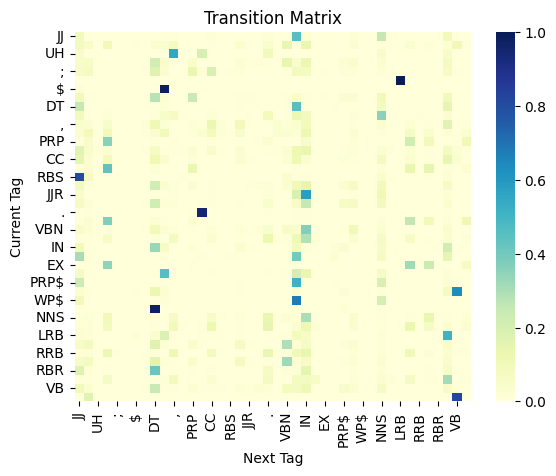

In [38]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# Convert the transmat matrix to a pandas DataFrame
transmat_df = pd.DataFrame(transmat, index=tags, columns=tags)

# Create a heatmap using seaborn
sns.heatmap(transmat_df, cmap="YlGnBu")

# Set the axis labels and title
plt.xlabel('Next Tag')
plt.ylabel('Current Tag')
plt.title('Transition Matrix')

# Display the plot
plt.show()


## Task 1: Similar to how we built the hidden state transition probability matrix as shown above, you will built the transition probability between the words. With this matrix write a function that can calculate the log likelihood given a sentence.

#### Step 1 : Matrice setup  
constructs a word transition matrix that represents the probabilities of transitioning from one word to another in a given dataset.<br />
The dataset consists of words from a sentences, thus the transition matrix will have many 0 so we store the it into a sparse matrix for memory efficiency.

Since it's take time to compute this matrix we saved it into a file, thus in the code we first check if it exist and compute it only if it doesn't.

In [39]:
WORD_TRANSITION_MATRIX_FILE_PATH = ROOT_PATH+'saved/matrix/word_transition_sparse_matrix.npz'

In [40]:
try:
    # load the word transition matrix
    with tqdm(total=1, desc="Loading word transition matrix", leave=True) as pbar:
        word_transition_matrix = scipy.sparse.load_npz(WORD_TRANSITION_MATRIX_FILE_PATH)
        #word_transition_matrix = np.load(WORD_TRANSITION_MATRIX_FILE_PATH)
        pbar.update(1)

except FileNotFoundError:
    print("Create the word transition matrix")
    # create a matrix to store the number of times a word follow an over one in the train data set sentences
    count_words_to_next_words = np.zeros((len(words), len(words)), dtype=int)
    # Store the sentences and words of the train data set
    sentences = list(data_train.sentence)
    word_list = list(data_train.Word)

    # iterate over each words of the train data set as we do before
    for i in tqdm(range(1, len(sentences)), position=0, leave=True):
        # if it isn't a first word of a sentence
        if sentences[i] == sentences[i - 1]:
            prevwordid = word2id[word_list[i - 1]]
            nextwordid = word2id[word_list[i]]
            count_words_to_next_words[prevwordid][nextwordid] += 1

    word_transition_matrix = np.zeros((len(words), len(words)))
    # Compute the number of times a word follow an over one in the train data set sentences
    sum_words_to_next_words = np.sum(count_words_to_next_words, axis=1)

    # For each word of the train data set
    for word1, wordid1 in tqdm(word2id.items(), position=0, leave=True):
        # We compute the probability to be folowed by a each over words
        for word2, wordid2 in word2id.items():
            if sum_words_to_next_words[wordid1] != 0:
                word_transition_matrix[wordid1][wordid2] = count_words_to_next_words[wordid1][wordid2] / sum_words_to_next_words[wordid1]
            else:
                word_transition_matrix[wordid1][wordid2] = 0

    # convert the word transition matrix to a compress sparse row (crs) matrix for memory efficiency
    word_transition_matrix = scipy.sparse.csr_matrix(word_transition_matrix)


    # save the word transition matrix
    scipy.sparse.save_npz(WORD_TRANSITION_MATRIX_FILE_PATH, word_transition_matrix)



Loading word transition matrix:   0%|          | 0/1 [00:00<?, ?it/s]


Create the word transition matrix


100%|██████████| 24552/24552 [09:36<00:00, 42.58it/s]


#### Step 2 : calculate the likelihood
calculates the log-likelihood of a given sentence using the word transition matrix. The log-likelihood represents the probability of observing the sentence based on the word transition probabilities in the training data

##### Formula

- likelihood: $ L = \prod\limits_{O\in LS}P(0|\lambda) $

- log-likelihood: $ \log L =  \sum\limits_{O\in LS}\log(P(0|\lambda))$

##### Implementation

In [41]:
# we consider that the probability to pick a words as first is the same for each words
PROBA_FIRST_WORD = 0 #  1 / len(words)

def calculate_log_likelihood(sentence: List[str], word_transition_matrix) -> float:
    """
    Calculate the log likelihood of a sentence given a word transition matrix.
    :param sentence: The sentence to calculate the log likelihood.
    :param word_transition_matrix: The word transition matrix.
    :return: The log likelihood of the sentence.
    """
    log_likelihood = PROBA_FIRST_WORD
    # in the loop the current word become the next word from the previous iteration, 
    # thus we need to initialize the next word with the first word of the sentence
    # so we dont do that twice
    next_word = sentence[0].lower()
    nextwordid = word2id.get(next_word, word2id['UNKNOWN'])

    for i in tqdm(range(len(sentence) - 1), position=0, leave=True):
        prev_word = next_word
        next_word = sentence[i + 1].lower()

        if prev_word in word2id and next_word in word2id:
            # get the indexes of the words
            prevwordid = nextwordid
            nextwordid = word2id.get(next_word, word2id['UNKNOWN'])
            # get the probability to get the next word given the current word
            transition_prob = word_transition_matrix[prevwordid, nextwordid]

            if transition_prob == 0:
               # the next word don't appears after the current word in the train data set
               return float('-inf')
            else:
                # we add the log probability of the transition to the log likelihood
                log_likelihood += np.log(transition_prob)
        else:
            # If either prev_word or next_word is not found in word2id, return -inf
            return float('-inf')

    return log_likelihood

#### Step 3 : test the likehihood on sentence 

In [42]:
sentences_to_test = [
    ["This", "is", "a", "protest", "about", "how", "the", "new", "law", "is", "not", "in", "the", "interest", "of", "the", "people"],
    ["The", "international", "conference", "will", "continue", "as", "planned", "on", "Friday"],
    ["Who", "are", "you", "?"],
    ["You", "are", "not", "me"],
    ["Do", "you", "expect", "to", "be", "happy", "to", "work", "late"],
    ["This", "is", "a", "test", "sentence"],
]

results_df = pd.DataFrame(columns=["Sentence", "Log Likelihood"])

for test_sentence in sentences_to_test:
    log_likelihood = calculate_log_likelihood(test_sentence, word_transition_matrix)
    temp_df = pd.DataFrame({"Sentence": [" ".join(test_sentence)], "Log Likelihood": [log_likelihood]})
    results_df = pd.concat([results_df, temp_df], ignore_index=True)

results_df.head()

 75%|███████▌  | 3/4 [00:00<00:00, 2957.21it/s]


Sentence  Log Likelihood
0  This is a protest about how the new law is not...      -70.964703
1  The international conference will continue as ...      -37.092219
2                                      Who are you ?      -15.990218
3                                     You are not me      -13.898883
4             Do you expect to be happy to work late      -35.118925

#### Now we will continue to constructing the HMM.

We will use the hmmlearn implementation to initialize the HMM Model

In [43]:
from hmmlearn import hmm
model = hmm.MultinomialHMM(n_components=len(tags), algorithm='viterbi', random_state=RANDOM_SEED)
model.startprob_ = startprob
model.transmat_ = transmat
model.emissionprob_ = emissionprob

#### Before using the HMM to predict the POS tags, we have to fix the training set as some of the words and tags in the test data might not appear in the training data so we collect this data to use it later.

In [44]:
# NB: the ~ syntax is used to invert the boolean mask
data_test.loc[~data_test['Word'].isin(words), 'Word'] = 'UNKNOWN'
word_test = list(data_test.Word)

samples = []
for i, val in enumerate(word_test):
    samples.append([word2id[val]])

# We count the number of words in each sentence
# lengths = []
# count = 0
# sentences = list(data_test.sentence)
# for i in tqdm(range(len(sentences)), position=0, leave=True):
#     if (i > 0) and (sentences[i] == sentences[i - 1]):
#         count += 1
#     elif i > 0:
#         lengths.append(count)
#         count = 1
#     else:
#         count = 1

# using panda solution which is faster :
lengths = data_test.groupby('sentence').size().tolist()



Now that we have the HMM ready lets predict the best path from them.<br />
Because it takes a lot of time (~20m), the pos_predict model is saved in a file. Thus if the file exist it will be loaded from it.

In [45]:
import pickle
POS_PREDICT_MODEL_FILE_PATH = ROOT_PATH+'saved/model/pos_predict_model.pkl'

In [46]:
try:
    with open(POS_PREDICT_MODEL_FILE_PATH, 'rb') as f:
        pos_predict = pickle.load(f)
        print("The model has been successfully loaded.")

except FileNotFoundError:
    # Predict the POS tags using the HMM, (take ~30m)
    pos_predict = model.predict(samples, np.array(lengths, dtype=int))

    # save the model
    with open(POS_PREDICT_MODEL_FILE_PATH, 'wb') as f:
        pickle.dump(pos_predict, f)

    print("The model has been successfully saved.")

pos_predict

The model has been successfully loaded.


array([ 5, 34,  5, ...,  0,  0,  0])

In [47]:
pos_tags = [id2tag[i] for i in pos_predict]
print(pos_tags[:10])

['FW', 'LRB', 'FW', 'VBP', 'IN', 'LRB', 'WP$', '``', 'UH', 'NNP']


##### Test for parralization.

We try to use parralle processing to improve the speed of the training of the model with dask and pyspark.

Below this is the processing of the model using the parralization framework named dask.

In [48]:
%%capture
!pip install "dask[complete]"

Still need some fixing, the computation is not done sequential so the output array is mixed, we need to reorder it.

In [49]:
if False: # to skip this cell when executing the wall notebook
    import dask.array as da
    from dask.distributed import Client, LocalCluster
    # from dask_cuda import LocalCUDACluster # only for linux
    from dask.diagnostics import ProgressBar


    # # Determine whether to use GPU or CPU
    # try:
    #     cluster = LocalCUDACluster()
    #     client = Client(cluster)
    #     print("Using CUDA")
    # except:
    #     client = Client()
    #     print("Using CPU")


    # Connect to a local Dask cluster that manages CPU ressources for parallel computing.
    with Client() as client:
        # We set the number of chunks that contains each dask array (i.e composed of chunks array) for parrallelism.
        n_chunks = 1000
        chunks_size = len(samples) // n_chunks

        # We convert our array into dask array for being used in parralel
        samples_dask = da.from_array(np.array(samples), chunks=chunks_size)
        sentences_lengths_dask = da.from_array(np.array(lengths, dtype=int), chunks=chunks_size)

        # We can now train our model in parallel using the dask array and joblib pipeline
        # Use the trained model to predict POS tags and display a progress bar

        # Predict POS tags in parallel
        with ProgressBar():
            global pos_predict
            pos_predict = model.predict(samples_dask, sentences_lengths_dask)

            # add it to try to reorder the results
            # Concatenate the results and sort them based on their original index
            # pos_predict = da.concatenate(pos_predict).compute()
            # idx = np.argsort(np.concatenate(sentences_lengths))
            # pos_predict = pos_predict[idx]

        client.close()

    pos_predict

The hmmlearn predict function will give the best probable path for the given sentence using the Viterbi algorithm.

## Task 2: Using the model parameters (startprob_, transmat_, emissionprob_) write the viterbi algorithm from scratch to calculate the best probable path and compare it with the hmmlearn implementation.

Now before using these matrices 

In [50]:
def Viterbi(pi: np.array, a: np.array, b: np.array, obs: List) -> np.array:
    """
    Write the viterbi algorithm from scratch to find the best probable path
    attr:
      pi: initial probabilities
      a: transition probabilities
      b: emission probabilities
      obs: list of observations
    return:
      array of the indices of the best hidden states
    """
    N = len(pi)
    T = len(obs)

    # Store the sum of probabilities of all the paths tha ends in state i when we are at time t
    delta = np.zeros((N, T))
    psi = np.zeros((N, T), dtype=int)

    # Base case: Fill in the first column of the table
    delta[:, 0] = np.log(pi) + np.log(b[:, obs[0]])

    # Inductive case: Fill in the rest of the table
    for t in range(1, T):
        for s in range(N):
          probabilities = delta[:, t - 1] + np.log(a[:, s]) + np.log(b[s, obs[t]])
          
          # Compute the maximum score and the corresponding argmax
          max_prob = np.max(probabilities)
          max_state = np.argmax(probabilities)

          # Store the sum of probabilities of all the paths that ends in state s when we are at time t
          delta[s, t] = max_prob

          # Store the state that maximizes the probability to go from state s to state t
          psi[s, t] = max_state

    # Backtrack to find the best path
    best_path = np.zeros(T, dtype=int)
    best_path[-1] = np.argmax(delta[:, -1])
    for t in range(T - 2, -1, -1):
        best_path[t] =psi[best_path[t + 1], t + 1]

    return best_path


To compare the results of the Viterbi algorithm from scratch with the results of the hmmlearn implementation,we call both functions on the same test data and compare the output.

In [51]:
import time
for test_sentence in sentences_to_test:
    # Next, we convert each word in the sample_sentence to its corresponding index (ID) using the word2id dictionary
    # If the word is not in the word2id dictionary (unknown word), we use the index for 'UNKNOWN'
    sample_indices = [word2id.get(word, word2id['UNKNOWN']) for word in test_sentence]

    # Convert the sample_indices into a 2D array for compatibility with hmmlearn's predict method
    sample_indices_2d = np.array([sample_indices])

    # Call Viterbi function and hmmlearn implementation with the same input data and compare results
    start_time = time.process_time()
    viterbi_result = Viterbi(model.startprob_, model.transmat_, model.emissionprob_, sample_indices)
    viterbi_time = time.process_time() - start_time
    start_time = time.process_time()
    hmmlearn_result = model.predict(sample_indices_2d, [len(sample_indices_2d)])
    hmmlearn_time = time.process_time() - start_time


    print("Test sentence:", test_sentence)
    print("Custom Viterbi result:", viterbi_result)
    print("Custom Viterbi time:", viterbi_time)
    print("hmmlearn result:", hmmlearn_result)
    print("hmmlearn time:", hmmlearn_time)

C:\Users\thoma\AppData\Local\Temp\ipykernel_14888\979655617.py:20: RuntimeWarning: divide by zero encountered in log
  delta[:, 0] = np.log(pi) + np.log(b[:, obs[0]])
C:\Users\thoma\AppData\Local\Temp\ipykernel_14888\979655617.py:25: RuntimeWarning: divide by zero encountered in log
  probabilities = delta[:, t - 1] + np.log(a[:, s]) + np.log(b[s, obs[t]])
C:\Users\thoma\AppData\Local\Temp\ipykernel_14888\979655617.py:20: RuntimeWarning: divide by zero encountered in log
  delta[:, 0] = np.log(pi) + np.log(b[:, obs[0]])
C:\Users\thoma\AppData\Local\Temp\ipykernel_14888\979655617.py:25: RuntimeWarning: divide by zero encountered in log
  probabilities = delta[:, t - 1] + np.log(a[:, s]) + np.log(b[s, obs[t]])
C:\Users\thoma\AppData\Local\Temp\ipykernel_14888\979655617.py:20: RuntimeWarning: divide by zero encountered in log
  delta[:, 0] = np.log(pi) + np.log(b[:, obs[0]])
C:\Users\thoma\AppData\Local\Temp\ipykernel_14888\979655617.py:25: RuntimeWarning: divide by zero encountered in lo

Test sentence: ['This', 'is', 'a', 'protest', 'about', 'how', 'the', 'new', 'law', 'is', 'not', 'in', 'the', 'interest', 'of', 'the', 'people']
Custom Viterbi result: [39 35  8 23 24  7  8  0 23 35  1 24  8 23 24  8 32]
Custom Viterbi time: 0.0
hmmlearn result: [39 35  8 23 24  7  8  0 23 35  1 24  8 23 24  8 32]
hmmlearn time: 0.046875
Test sentence: ['The', 'international', 'conference', 'will', 'continue', 'as', 'planned', 'on', 'Friday']
Custom Viterbi result: [ 8  0 23 41 40  1 22 24  8]
Custom Viterbi time: 0.0
hmmlearn result: [ 8  0 23 41 40  1 22 24  8]
hmmlearn time: 0.03125
Test sentence: ['Who', 'are', 'you', '?']
Custom Viterbi result: [32 37 12 20]
Custom Viterbi time: 0.0
hmmlearn result: [32 37 12 20]
hmmlearn time: 0.046875
Test sentence: ['You', 'are', 'not', 'me']
Custom Viterbi result: [32 37  1 12]
Custom Viterbi time: 0.0
hmmlearn result: [32 37  1 12]
hmmlearn time: 0.015625
Test sentence: ['Do', 'you', 'expect', 'to', 'be', 'happy', 'to', 'work', 'late']
Custom 

C:\Users\thoma\AppData\Local\Temp\ipykernel_14888\979655617.py:20: RuntimeWarning: divide by zero encountered in log
  delta[:, 0] = np.log(pi) + np.log(b[:, obs[0]])
C:\Users\thoma\AppData\Local\Temp\ipykernel_14888\979655617.py:25: RuntimeWarning: divide by zero encountered in log
  probabilities = delta[:, t - 1] + np.log(a[:, s]) + np.log(b[s, obs[t]])
C:\Users\thoma\AppData\Local\Temp\ipykernel_14888\979655617.py:20: RuntimeWarning: divide by zero encountered in log
  delta[:, 0] = np.log(pi) + np.log(b[:, obs[0]])
C:\Users\thoma\AppData\Local\Temp\ipykernel_14888\979655617.py:25: RuntimeWarning: divide by zero encountered in log
  probabilities = delta[:, t - 1] + np.log(a[:, s]) + np.log(b[s, obs[t]])


### Task 3: Let's try to form our own HMM
In this task you will try to formulate your own HMM. Image a toy example that you think that closely relates to a Hidden Markov Model.

Steps:
 1. Define your hidden states
 2. Define your observable states
 3. Randomly generate your observations

Below is an example to demonstrate:

-In this toy HMM example, we have two hidden states 'healthy' and 'sick' these states relate to the state of a pet. In this example we cannot exactly know the situation of the pet if it is 'healthy' or 'sick'

-The observable states in this formulation is the what our pet is doing, whether it is sleeping, eating or pooping. We ideally want to determine if the pet is sick or not using these observable states


```python
hidden_states = ['healthy', 'sick']
observable_states = ['sleeping', 'eating', 'pooping']
observations = []
for i in range(100):
  observations.append(random.choice(observable_states))
```

TASK 3: Now try to formulate your HMM here.

In [52]:
import numpy as np
import random
from hmmlearn import hmm

# Define the hidden states and observable states
hidden_states = ['sunny', 'rainy', 'cloudy']
observable_states = ['walking', 'shopping', 'staying home']

# Define the initial probabilities, transition probabilities, and emission probabilities
initial_probabilities = np.array([0.6, 0.3, 0.1])

transition_probabilities = np.array([
    [0.7, 0.2, 0.1],  # sunny
    [0.3, 0.4, 0.3],  # rainy
    [0.2, 0.3, 0.5]   # cloudy
])

emission_probabilities = np.array([
    [0.6, 0.3, 0.1],  # sunny
    [0.1, 0.3, 0.6],  # rainy
    [0.3, 0.4, 0.3]   # cloudy
])

# Generate random observations of people's activities
observations = []
for i in range(100):
    observations.append(random.choice(observable_states))

# Map the observations to IDs
obs2id = {obs: i for i, obs in enumerate(observable_states)}
observations_ids = [obs2id[obs] for obs in observations]

### Now let compare both hmmlearn and custom viterbi on our HMM

##### Hmmlearn

In [53]:
# Create an HMM using the hmmlearn library
model = hmm.MultinomialHMM(n_components=len(hidden_states), random_state=42)
model.startprob_ = initial_probabilities
model.transmat_ = transition_probabilities
model.emissionprob_ = emission_probabilities

# Predict the hidden states (weather) based on the observations (activities)
hidden_states_predict = model.predict(np.array(observations_ids).reshape(-1, 1))

# Map the predicted hidden states back to their names
id2hidden = {i: hidden for i, hidden in enumerate(hidden_states)}
hidden_states_names = [id2hidden[state] for state in hidden_states_predict]
obs_hmm = observations

df = pd.DataFrame({'Observations': observations, 'Predicted Hidden States': hidden_states_names})
df.head()

Observations Predicted Hidden States
0       walking                   sunny
1       walking                   sunny
2  staying home                   sunny
3       walking                   sunny
4      shopping                   sunny

##### custom viterbi

In [54]:
# Predict the hidden states (weather) based on the observations (activities) using the custom Viterbi function
hidden_states_predict_viterbi = Viterbi(initial_probabilities, transition_probabilities, emission_probabilities, observations_ids)

# Map the predicted hidden states back to their names
id2hidden = {i: hidden for i, hidden in enumerate(hidden_states)}
hidden_states_names_viterbi = [id2hidden[state] for state in hidden_states_predict_viterbi]

obs_viterbi = observations

df = pd.DataFrame({'Observations': observations, 'Predicted Hidden States': hidden_states_names_viterbi})
df.head()


Observations Predicted Hidden States
0       walking                   sunny
1       walking                   sunny
2  staying home                   sunny
3       walking                   sunny
4      shopping                   sunny

##### Observation 

In [55]:
import pandas as pd

output_df = pd.DataFrame({
    "Observations viterbi": obs_viterbi,
    "Predicted Hidden States (Viterbi)": hidden_states_names_viterbi,
    "Observations hmmlearn": obs_hmm,
    "Predicted Hidden States (Hmm)": hidden_states_names
    
})

# Display the output DataFrame
# print(output_df)

output_df.head()

Observations viterbi Predicted Hidden States (Viterbi)  \
0              walking                             sunny   
1              walking                             sunny   
2         staying home                             sunny   
3              walking                             sunny   
4             shopping                             sunny   

  Observations hmmlearn Predicted Hidden States (Hmm)  
0               walking                         sunny  
1               walking                         sunny  
2          staying home                         sunny  
3               walking                         sunny  
4              shopping                         sunny

Even tough we have generated the data randomly, for the learning purposes, let's try to learn an HMM from this data. For this we have to construct the Baum-Welch algorithm from scratch. Below is the skeleton of the Baum-Welch learning algorithm.

## TASK 4: Complete the forward and backward probs functions in the Baum-Welch algorithm and try it with your formulated HMM.

In [56]:

def baum_welch(observations, observations_vocab, n_hidden_states):
    """
    Baum-Welch algorithm for estimating the HMM parameters
    :param observations: observations
    :param observations_vocab: observations vocabulary
    :param n_hidden_states: number of hidden states to estimate
    :return: a, b (transition matrix and emission matrix)
    """

    def forward_probs(observations, observations_vocab, n_hidden_states, a_, b_) -> np.array:
        """
        Computes the forward probabilities of a path for a Hidden Markov Model with the given parameters.

        :param observations : observations
        :param observations_vocab: observation vocabulary
        :param n_hidden_states: number of hidden states
        :param a_: estimated alpha
        :param b_: estimated beta
        :return: refined alpha_
        """
        # Calculate the initial probability for each state, which is equiprobable
        a_start = 1 / n_hidden_states
        # Initialize alpha with zeros
        alpha_ = np.zeros((n_hidden_states, len(observations)), dtype=float)

        # -- Init: t = 1 --
        # For the first probability, we compute the probability of each state to be the first one (i.e a_start)
        # time the probability of the first observation made in that state stored in b_
        
        # First we search for the index of the first observation in the observation vocabulary
        # NB: np.where returns a tuple that contains an array of indices that satisfy the condition
        # hence we first select the first dimension with [0] and then the first element of that array with [0]
        observation_index = np.where(observations_vocab == observations[0])[0][0]

        # Then we compute alpha_1(i) for each state i
        alpha_[:, 0] = a_start * b_[:, observation_index]
        
        # -- Induction: t > 1 --
        # Compute forward probabilities for the rest of the observation sequence
        for t in range(1, len(observations)):
            # For each state j, we compute the probability of being in that state at time t with this observation
            for j in range(n_hidden_states):
                prob = 0

                # Get the index of the observation in the observation vocabulary list
                observation_index = np.where(observations_vocab == observations[t])[0][0]

                # We first compute the probability to start in each state i at time t-1 and moving
                # to the state j at time t.
                for i in range(n_hidden_states):
                    prob += alpha_[i, t - 1] * a_[i, j]

                
                # Then we multiply this probability to be in state j at time t by the probability
                # to observe the current observation in that state
                alpha_[j, t] = b_[j, observation_index] * prob

        return alpha_

    def backward_probs(observations, observations_vocab, n_hidden_states, a_, b_) -> np.array:
        """
        Computes the backward probabilities of a path for a Hidden Markov Model with the given parameters.
        :param observations: observations
        :param observations_vocab: observation vocabulary
        :param n_hidden_states: number of hidden states
        :param a_: estimated alpha
        :param b_: estimated beta
        :return: refined beta_
        """
        # Initialize beta with zeros
        beta_ = np.zeros((n_hidden_states, len(observations)), dtype=float)
        # The 'probability' to end up in a state at time T is 1 because we can choose
        # in which state we end up, there is no probability to end up in a state
        beta_[:, -1:] = 1

        # -- Induction: t < T --
        # Compute backward probabilities for the rest of the observation sequence
        # NB: the stop index is -1 because t decrease and we include 0
        for t in range(len(observations) - 2, -1, -1):
            # For each state i, we compute the probability of observing the rest of the sequence
            # from this state i.
            for i in range(n_hidden_states):
                prob = 0

                # Get the index of the observation in the observation vocabulary list
                observation_index = np.where(observations_vocab == observations[t + 1])[0][0]

                # We compute the probaility to observe the rest of the sequence from time t+1
                # for each state j times the probability to move from state i to state j
                for j in range(n_hidden_states):
                    prob += beta_[j, t + 1] * a_[i, j] 

                # Then we multiply this computed probability by the probability to observe the
                # current observation in state i
                beta_[i, t] = b_[j, observation_index] * prob

        return beta_

    def compute_gamma(alfa, beta, observations, vocab, n_samples, a_, b_) -> np.array:
        """

        :param alfa:
        :param beta:
        :param observations:
        :param vocab:
        :param n_samples:
        :param a_:
        :param b_:
        :return:
        """
        # gamma_prob = np.zeros(n_samples, len(observations))
        gamma_prob = np.multiply(alfa, beta) / sum(np.multiply(alfa, beta))
        return gamma_prob

    def compute_sigma(alfa, beta, observations, vocab, n_samples, a_, b_) -> np.array:
        """

        :param alfa:
        :param beta:
        :param observations:
        :param vocab:
        :param n_samples:
        :param a_:
        :param b_:
        :return:
        """
        sigma_prob = np.zeros((n_samples, len(observations) - 1, n_samples), dtype=float)
        denomenator = np.multiply(alfa, beta)
        for i in range(len(observations) - 1):
            for j in range(n_samples):
                for k in range(n_samples):
                    index_in_vocab = np.where(vocab == observations[i + 1])[0][0]
                    sigma_prob[j, i, k] = (alfa[j, i] * beta[k, i + 1] * a_[j, k] * b_[k, index_in_vocab]) / sum(
                        denomenator[:, j])
        return sigma_prob

    # initialize A ,B
    a = np.ones((n_hidden_states, n_hidden_states)) / n_hidden_states
    b = np.ones((n_hidden_states, len(observations_vocab))) / len(observations_vocab)
    for iter in tqdm(range(2000), position=0, leave=True):

        # E-step caclculating sigma and gamma
        alfa_prob = forward_probs(observations, observations_vocab, n_hidden_states, a, b)  #
        beta_prob = backward_probs(observations, observations_vocab, n_hidden_states, a, b)  # , beta_val
        gamma_prob = compute_gamma(alfa_prob, beta_prob, observations, observations_vocab, n_hidden_states, a, b)
        sigma_prob = compute_sigma(alfa_prob, beta_prob, observations, observations_vocab, n_hidden_states, a, b)

        # M-step caclculating A, B matrices
        a_model = np.zeros((n_hidden_states, n_hidden_states))
        for j in range(n_hidden_states):  # calculate A-model
            for i in range(n_hidden_states):
                for t in range(len(observations) - 1):
                    a_model[j, i] = a_model[j, i] + sigma_prob[j, t, i]
                normalize_a = [sigma_prob[j, t_current, i_current] for t_current in range(len(observations) - 1) for
                               i_current in range(n_hidden_states)]
                normalize_a = sum(normalize_a)
                if normalize_a == 0:
                    a_model[j, i] = 0
                else:
                    a_model[j, i] = a_model[j, i] / normalize_a

        b_model = np.zeros((n_hidden_states, len(observations_vocab)))

        for j in range(n_hidden_states):
            for i in range(len(observations_vocab)):
                indices = [idx for idx, val in enumerate(observations) if val == observations_vocab[i]]
                numerator_b = sum(gamma_prob[j, indices])
                denominator_b = sum(gamma_prob[j, :])
                if denominator_b == 0:
                    b_model[j, i] = 0
                else:
                    b_model[j, i] = numerator_b / denominator_b

        a = a_model
        b = b_model
    return a, b




##### test the baum welch

In [57]:
import random

hidden_states = ['healthy', 'sick']
observable_states = ['sleeping', 'eating', 'pooping']
observable_map = {'sleeping': 0, 'eating': 1, 'pooping': 2}
observations = []
for i in range(100):
    observations.append(observable_map[random.choice(observable_states)])

A, B = baum_welch(observations=observations, observations_vocab=np.array(list(observable_map.values())),
                  n_hidden_states=2)


100%|██████████| 2000/2000 [00:08<00:00, 245.00it/s]


In [58]:
# Create pandas DataFrames for A and B
A_df = pd.DataFrame(A, columns=hidden_states, index=hidden_states)
B_df = pd.DataFrame(B, columns=observable_states, index=hidden_states)

A_df.head()


healthy  sick
healthy      0.5   0.5
sick         0.5   0.5

In [59]:
B_df.head()

sleeping  eating  pooping
healthy      0.33    0.32     0.35
sick         0.33    0.32     0.35

In [60]:
# Create pandas DataFrame for observations
observable_map_inv = {v: k for k, v in observable_map.items()}
observations_states = [observable_map_inv[o] for o in observations]
observations_df = pd.DataFrame({'Observation_Index': list(range(len(observations))),
                                 'Observation_Value': observations,
                                 'Observation_State': observations_states})
observations_df.head()

Observation_Index  Observation_Value Observation_State
0                  0                  1            eating
1                  1                  1            eating
2                  2                  2           pooping
3                  3                  1            eating
4                  4                  1            eating

#### Task 3 bis: sentiment analysis

In [61]:
from sklearn.preprocessing import LabelEncoder

# Preprocess text
def preprocess_text(text):
    # Remove URLs, mentions, and hashtags
    text = re.sub(r"(?:\@|\#|https?\://)\S+", "", text)
    # Remove punctuation
    text = re.sub(r"[^a-zA-Z\s]", "", text)
    # Convert to lowercase
    text = text.lower()
    return text

# Load your dataset
data = pd.read_csv("./data/Tweet Sentiment Analysis.csv", encoding='latin1') 
data['senti'] = data['senti'].map({0: 'negative', 2: 'neutral', 4: 'positive'})
sentiments = data['senti']
texts = data['tweet']

texts = [preprocess_text(text) for text in texts]

# Define the hidden states and observable states
hidden_states = ['positive', 'negative', 'neutral']
observable_states = list(set(word for text in texts for word in text.split()))

# Encode the sentiments and words as integers
hidden_encoder = LabelEncoder()
hidden_ids = hidden_encoder.fit_transform(sentiments)

obs_encoder = LabelEncoder()
obs_encoder.fit(observable_states)
observations_ids = [obs_encoder.transform(text.split()) for text in texts]

# Estimate initial probabilities, transition probabilities, and emission probabilities
initial_probabilities = np.zeros(len(hidden_states))
transition_probabilities = np.zeros((len(hidden_states), len(hidden_states)))
emission_probabilities = np.zeros((len(hidden_states), len(observable_states)))

for hidden_id, observation_id in zip(hidden_ids, observations_ids):
    initial_probabilities[hidden_id] += 1
    for i in range(len(observation_id)):
        emission_probabilities[hidden_id, observation_id[i]] += 1
        if i < len(observation_id) - 1:
            transition_probabilities[hidden_id, hidden_ids[i + 1]] += 1


# Custom Viterbi function
def Viterbi(pi: np.array, a: np.array, b: np.array, obs_list: list) -> list:
    best_paths = []
    for obs in obs_list:
        n_states = len(pi)
        T = len(obs)

        # Initialize the dynamic programming table
        dp = np.zeros((n_states, T))
        ptr = np.zeros((n_states, T), dtype=int)

        # Base case: Fill in the first column of the table
        dp[:, 0] = pi * b[:, obs[0]]

        # Inductive case: Fill in the rest of the table
        for t in range(1, T):
            for s in range(n_states):
                max_prob = -np.inf
                max_state = -1
                for prev_s in range(n_states):
                    prob = dp[prev_s, t - 1] * a[prev_s, s] * b[s, obs[t]]
                    if prob > max_prob:
                        max_prob = prob
                        max_state = prev_s
                dp[s, t] = max_prob
                ptr[s, t] = max_state

        # Backtrack to find the best path
        best_path = np.zeros(T, dtype=int)
        best_path[-1] = np.argmax(dp[:, -1])
        for t in range(T - 2, -1, -1):
            best_path[t] = ptr[best_path[t + 1], t + 1]
        best_paths.append(best_path)

    return best_paths

In [65]:
initial_probabilities /= np.sum(initial_probabilities)
transition_probabilities /= np.sum(transition_probabilities, axis=1, keepdims=True)
emission_probabilities /= np.sum(emission_probabilities, axis=1, keepdims=True)

# Predict the hidden states (sentiments) based on the observations (words) using the custom Viterbi function
hidden_states_predict_viterbi = Viterbi(initial_probabilities, transition_probabilities, emission_probabilities, observations_ids)

# Map the predicted hidden states back to their names
id2hidden = {i: hidden for i, hidden in enumerate(hidden_states)}
hidden_states_names_viterbi = [[id2hidden[state] for state in path] for path in hidden_states_predict_viterbi]

import pandas as pd
from scipy import stats

# Get the mode of the predicted sentiments for each sentence
sentiment_modes = []
for path in hidden_states_names_viterbi:
    sentiment_modes.append(stats.mode(path)[0][0])

# Create a DataFrame with the tweet texts, true sentiments, and their predicted sentiments
result_df = pd.DataFrame({'Tweet': texts, 'True Sentiment': sentiments, 'Predicted Sentiment': sentiment_modes})

# Display the DataFrame
result_df.head(20)

C:\Users\thoma\AppData\Local\Temp\ipykernel_14888\1953809485.py:18: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  sentiment_modes.append(stats.mode(path)[0][0])
C:\Users\thoma\AppData\Local\Temp\ipykernel_14888\1953809485.py:18: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can be used instead, see https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.mode.html.
  sentiment_modes.append(stats.mode(path)[0][0])


Tweet True Sentiment  \
0    ua can wait for me im on the ground trying to...       negative   
1   i hate time warner soooo wish i had vios cant ...       negative   
2    oh we are sure its not planned but it occurs ...       negative   
3   tom shanahans latest column on sdsu and its nc...        neutral   
4                 found the self driving car iwoqsvdu        neutral   
5    arrived in yyz to take our flight to taiwan r...       negative   
6                   driverless cars  whats the point        negative   
7   how can you not love obama he makes jokes abou...       positive   
8                 safeway is very rock n roll tonight       positive   
9                      rt  the ultimate jquery list          neutral   
10  i saw night at the museum battle of the swiths...        neutral   
11                          history exam studying ugh       negative   
12   missed this each is newer generation id start...        neutral   
13  is being fucked by time warner cable didnt kno...       negative   
14            i hope the girl at work  buys my kindle        neutral   
15                                  good luck to you        positive   
16   needs someone to explain lambda calculus to him        negative   
17   yeah looks like that only quotbusyquot is fuc...       negative   
18                                      loves twitter       positive   
19   i really dont want atampt phone servicethey s...       negative   

   Predicted Sentiment  
0             positive  
1             positive  
2             positive  
3             negative  
4             negative  
5             positive  
6             positive  
7             positive  
8              neutral  
9             negative  
10            negative  
11            positive  
12            negative  
13            positive  
14            positive  
15             neutral  
16            positive  
17            positive  
18            negative  
19            positive

In [64]:
# Initialize the Multinomial HMM model
model = hmm.MultinomialHMM(n_components=len(hidden_states), n_iter=100)
model.startprob_ = initial_probabilities
model.transmat_ = transition_probabilities
model.emissionprob_ = emission_probabilities

# Train the model using the Baum-Welch algorithm
X_lengths = [len(obs) for obs in observations_ids]
X_concat = np.concatenate([obs for obs in observations_ids])
model.fit(np.atleast_2d(X_concat).T, lengths=X_lengths)

# Predict the hidden states (sentiments) based on the observations (words) using the model.decode() method
hidden_states_predict_bw = [model.decode(np.atleast_2d(obs).T)[1] for obs in observations_ids]

# Map the predicted hidden states back to their names
hidden_states_names_bw = [[id2hidden[state] for state in path] for path in hidden_states_predict_bw]

# Get the mode of the predicted sentiments for each sentence
sentiment_modes_bw = []
for path in hidden_states_names_bw:
    sentiment_modes_bw.append(stats.mode(path)[0][0])

# Create a DataFrame with the tweet texts, true sentiments, and their predicted sentiments using the Baum-Welch algorithm
result_df_bw = pd.DataFrame({'Tweet': texts, 'True Sentiment': sentiments, 'Predicted Sentiment': sentiment_modes_bw})

# Display the filtered DataFrame
result_df_bw.head(10)

Even though the 'startprob_' attribute is set, it will be overwritten during initialization because 'init_params' contains 's'
Even though the 'transmat_' attribute is set, it will be overwritten during initialization because 'init_params' contains 't'
C:\Users\thoma\AppData\Local\Temp\ipykernel_14888\2717419161.py:21: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  sentiment_modes_bw.append(stats.mode(path)[0][0])
C:\Users\thoma\AppData\Local\Temp\ipykernel_14888\2717419161.py:21: DeprecationWarning: Support for non-numeric arrays has been deprecated as of SciPy 1.9.0 and will be removed in 1.11.0. `pandas.DataFrame.mode` can

Tweet True Sentiment  \
0   ua can wait for me im on the ground trying to...       negative   
1  i hate time warner soooo wish i had vios cant ...       negative   
2   oh we are sure its not planned but it occurs ...       negative   
3  tom shanahans latest column on sdsu and its nc...        neutral   
4                found the self driving car iwoqsvdu        neutral   
5   arrived in yyz to take our flight to taiwan r...       negative   
6                  driverless cars  whats the point        negative   
7  how can you not love obama he makes jokes abou...       positive   
8                safeway is very rock n roll tonight       positive   
9                     rt  the ultimate jquery list          neutral   

  Predicted Sentiment  
0            negative  
1            positive  
2            positive  
3            negative  
4            positive  
5            negative  
6            positive  
7             neutral  
8            negative  
9            negative

In [66]:
# Calculate the number of correct predictions for the custom Viterbi algorithm
correct_viterbi = np.sum(result_df['True Sentiment'] == result_df['Predicted Sentiment'])

# Calculate the accuracy for the custom Viterbi algorithm
accuracy_viterbi = correct_viterbi / len(result_df) * 100

# Calculate the number of correct predictions for the Baum-Welch algorithm
correct_bw = np.sum(result_df_bw['True Sentiment'] == result_df_bw['Predicted Sentiment'])

# Calculate the accuracy for the Baum-Welch algorithm
accuracy_bw = correct_bw / len(result_df_bw) * 100

# Compare the accuracies
print(f"Accuracy of the custom Viterbi algorithm: {accuracy_viterbi:.2f}%")
print(f"Accuracy of the Baum-Welch algorithm: {accuracy_bw:.2f}%")

Accuracy of the custom Viterbi algorithm: 23.07%
Accuracy of the Baum-Welch algorithm: 35.21%
